## Predict a fraud
In this notebook, I'll work on detecting fraud with prioritizing correctly finding fraud rather than correctly labeling non-fraudulent transactions

The data is taken from here:<br>
https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

In [2]:
cc_df = pd.read_csv('credit_card.csv')

print("The data frame shape is:", cc_df.shape)

cc_df.head()

The data frame shape is: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# number of frauds
(cc_df['Class'] == 1).sum()

492

### About the data
The dataset presents transactions that occurred in two days in September 2013 by European cardholders.
Due to confidentiality, the features are represented as V1, V2, etc. The 'Time' feature contains the seconds elapsed between each transaction and the first transaction in the dataset. The 'Amount' feature is the amount of the purchase. 'Class' is the dependent column; 1 means it's a fraud, 0 it's not a fraud. <br>As it can be seen, there are few frauds in the dataset, 492 out of 283807 (0.173%, very unbalanced).

In [4]:
# check for null values and type
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [5]:
# Checking into 'Time' since seems to a bit arbitrary
print(cc_df['Time'].describe())

# it has a huge std and the values continuingly increasing (time past); therefore, dropping this column 
cc_df = cc_df.drop('Time', axis=1)

cc_df.head()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Under sample the non-fraud class
First try, under example. There will be the same amount of fraud and not a fraud.

In [6]:
# df with only frauds
fraud_df = cc_df[cc_df['Class'] == 1]

# df with only non-frauds
non_fraud_df = cc_df[cc_df['Class'] == 0]

# under sample non frauds
tmp = non_fraud_df.sample(n=492)

# concatenate the fraud and non fraud (492 rows each)
under_smp = pd.concat([fraud_df, tmp])

# mix the data
under_smp = under_smp.sample(frac=1, random_state=3)

# reset the index
under_smp = under_smp.reset_index(drop=True)

under_smp.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.340391,2.015233,-2.777330,3.812024,-0.461729,-1.152022,-2.001959,0.548681,-2.344042,-3.076699,...,0.299769,-0.583283,-0.187696,-0.329256,0.732328,0.058080,0.553143,0.318832,1.75,1
1,-0.528744,1.140656,2.749696,2.248082,-0.520847,0.349253,0.051142,0.111876,-0.899911,0.416558,...,0.373029,1.100065,-0.139220,0.438694,-0.469598,0.121542,0.064671,0.158500,26.59,0
2,-16.598665,10.541751,-19.818982,6.017295,-13.025901,-4.128779,-14.118865,11.161144,-4.099551,-9.222826,...,1.725853,-1.151606,-0.680052,0.108176,1.066878,-0.233720,1.707521,0.511423,99.99,1
3,-0.157990,0.808268,-0.209369,-0.889306,0.862206,0.110840,0.450504,-0.729776,-0.103142,-0.220816,...,0.566345,-0.906639,0.212416,0.176677,-0.494347,0.101874,-0.133579,-0.015417,3.38,0
4,-4.384221,3.264665,-3.077158,3.403594,-1.938075,-1.221081,-3.310317,-1.111975,-1.977593,-3.288204,...,2.076383,-0.990303,-0.330358,0.158378,0.006351,-0.493860,-1.537652,-0.994022,45.64,1
5,1.176718,0.225465,0.180054,0.745292,-0.373010,-1.333548,0.438459,-0.385405,-0.246557,-0.061283,...,-0.001115,-0.032230,-0.066995,0.770536,0.535563,0.340190,-0.054639,0.018470,48.00,0
6,-1.644403,3.129852,-2.576977,3.415573,-0.448525,-1.241893,-1.991652,1.002665,-2.809071,-4.153692,...,0.417762,-0.648576,-0.318617,-0.680413,0.389869,0.055750,0.394682,0.298821,6.62,1
7,-0.781530,0.557188,1.510557,0.171665,0.204967,0.667720,0.380158,0.385883,0.295963,-1.509618,...,-0.326181,-0.862129,-0.071215,0.550284,0.368185,-0.717274,0.112392,0.110880,69.99,0
8,2.149687,-0.615148,-1.792341,-0.663043,-0.075483,-0.869555,0.059361,-0.352590,-0.711351,0.849685,...,-0.335943,-0.312376,0.047117,-0.391574,0.207424,0.117806,-0.041071,-0.076746,24.99,0
9,2.049329,-1.592980,-0.331292,-1.153714,-2.059141,-1.484827,-0.963888,-0.284422,-1.118354,1.476460,...,-0.542406,-1.312141,0.594530,0.822952,-0.800522,-0.727730,0.002176,-0.016460,99.87,0


In [7]:
# separate to X and y
X = under_smp.iloc[:, :-1]
y = under_smp['Class']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=24)

In [8]:
# train using Random forest
rfc = RandomForestClassifier(n_estimators=10, max_depth=3)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [9]:
# function to calculate recall, precision, correctly and f1
def calc_values(cm, name):
    # recall is the TP / #of actual positive
    recall = cm[1][1] / (cm[1][1] + cm[1][0])
    # precision is TP / #of predicted positive
    precision =  cm[1][1] / (cm[1][1] + cm[0][1])
    # correctly identified negative values
    specificity = cm[0][0] / (cm[0][0] + cm[0][1])
    
    # calcualte f1
    score = 2 * ((recall * precision) / (recall + precision))
    # add f1 score to a dictionary
    f1 = score
    
    print("Using {};\nRecall is {}, \nPrecision is {} \nSpecificity {}.".format(name, recall, precision, specificity))
    print("f1 score is:", score)
    
    return f1

In [10]:
rfc_pred = rfc.predict(X_test)
cm = confusion_matrix(y_test, rfc_pred)
cm

# the order of the CM is
# true negative,  false positive
# false negative, true positive

array([[165,   1],
       [ 22, 137]], dtype=int64)

In [11]:
# ROC curve
y_pred_proba = rfc.predict_proba(X_test)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba)

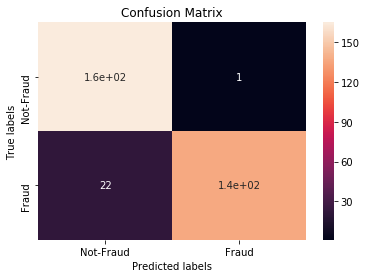

In [12]:
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not-Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not-Fraud', 'Fraud']);

In [13]:
# get values for this model
f = calc_values(cm, "under_sampled_forest")

# create a dictionary with the name and its f1 score
f1_score = {"under_sampled_forest": f}

Using under_sampled_forest;
Recall is 0.8616352201257862, 
Precision is 0.9927536231884058 
Specificity 0.9939759036144579.
f1 score is: 0.9225589225589226


In [14]:
# compare to logistic regression
lrg = LogisticRegression(penalty='l2', solver='liblinear') # lasso
lrg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
lrg_pred = lrg.predict(X_test)
cm = confusion_matrix(y_test, lrg_pred)
cm

array([[160,   6],
       [ 14, 145]], dtype=int64)

In [16]:
# get values for lasso regression
f1 = calc_values(cm, "under_sampled_lasso")

# append its f1 to dict
f1_score.update({"under_sampled_lasso": f1})

Using under_sampled_lasso;
Recall is 0.9119496855345912, 
Precision is 0.9602649006622517 
Specificity 0.963855421686747.
f1 score is: 0.935483870967742


In [17]:
# ROC Lasso
y_pred_proba = lrg.predict_proba(X_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba)

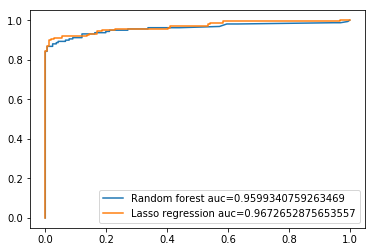

In [18]:
# plot the two curves
plt.plot(fpr1,tpr1,label="Random forest auc="+str(auc1))
plt.plot(fpr2,tpr2,label="Lasso regression auc="+str(auc2))
plt.legend(loc=4)
plt.show()

## Next, compare it to SMOTE
SMOTE creates syntactic frauds (not duplicate values) based on its neighbors

In [19]:
# separate to X and y from origianl df
X = cc_df.iloc[:, :-1]
y = cc_df['Class']

In [20]:
ones = (y == 1).sum()
zeros = (y == 0).sum()

print("Before SMOTE; there are {} frauds and {} not frauds".format(ones, zeros))

smt = SMOTE(random_state=24)
# X_SMOTE, y_SMOTE = smt.fit_sample(X_train, y_train)
X_SMOTE, y_SMOTE = smt.fit_sample(X, y)


ones = (y_SMOTE == 1).sum()
zeros = (y_SMOTE == 0).sum()
print("After SMOTE; y has {} frauds and {} not frauds".format(ones, zeros))

Before SMOTE; there are 492 frauds and 284315 not frauds
After SMOTE; y has 284315 frauds and 284315 not frauds


In [21]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=24)

After we matched the sizes of the classes, I'll repeat the same procedure as above to check for precision

In [22]:
# random forest
rfc_pred = rfc.predict(X_test)
cm = confusion_matrix(y_test, rfc_pred)
cm

array([[92321,  1499],
       [   23,   144]], dtype=int64)

In [23]:
# get values for lasso regression
f1 = calc_values(cm, "SMOTE_random_forest")

# append its f1 to dict
f1_score.update({"SMOTE_random_forest": f1})

Using SMOTE_random_forest;
Recall is 0.8622754491017964, 
Precision is 0.08764455264759587 
Specificity 0.9840225964613089.
f1 score is: 0.15911602209944753


In [24]:
# ROC curve forest
y_pred_proba = rfc.predict_proba(X_test)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba)

In [25]:
# lasso regression
lrg_pred = lrg.predict(X_test)
cm = confusion_matrix(y_test, lrg_pred)
cm

array([[89670,  4150],
       [   17,   150]], dtype=int64)

In [26]:
# get values for lasso regression
f1 = calc_values(cm, "SMOTE_lasso")

# append its f1 to dict
f1_score.update({"SMOTE_laso": f1})

Using SMOTE_lasso;
Recall is 0.8982035928143712, 
Precision is 0.03488372093023256 
Specificity 0.9557663611170326.
f1 score is: 0.0671591672263264


In [27]:
# ROC Lasso
y_pred_proba = lrg.predict_proba(X_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba)

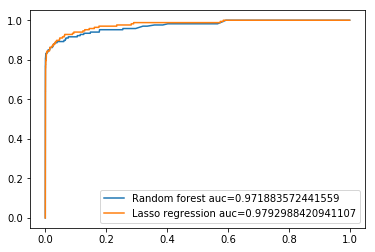

In [28]:
# plot the two curves
plt.plot(fpr1,tpr1,label="Random forest auc="+str(auc1))
plt.plot(fpr2,tpr2,label="Lasso regression auc="+str(auc2))
plt.legend(loc=4)
plt.show()

## Using regular oversampling
Lastly, using 'regular' oversampling, here the fraud class will be multiplied several times. Since we don't want to have the same exact data (copy) in the training and the test, first split the data, then copy the underrepresented class to match the size and train the data (although the test group will have very few from the fraud class, therefore the test size will by 35%)

In [29]:
# Separate input features and target
y = cc_df['Class']
X = cc_df.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=243)

# concatenate our training data back together
tmp = pd.concat([X_train, y_train], axis=1)

# mix the data
tmp = tmp.sample(frac=1, random_state=3)

tmp.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
184448,-3.253089,-1.182952,-0.432007,0.490969,-2.109627,1.743469,1.502307,0.492965,-1.560480,0.499926,...,-0.443988,-0.569052,-0.706064,0.247650,0.549410,-0.414145,0.359230,-0.564331,564.00,0
174226,1.684886,-0.446886,-2.134385,1.204580,0.744735,-0.091466,0.672364,-0.161798,0.023224,0.353587,...,0.166996,0.206735,-0.184818,0.218896,0.424004,-0.529872,-0.061202,-0.040061,186.14,0
210568,2.039951,-0.050436,-1.822929,0.257979,0.440332,-0.385512,-0.074735,0.066006,0.553760,-0.157928,...,-0.346126,-1.016137,0.330044,0.141654,-0.339795,0.180694,-0.076644,-0.048042,0.89,0
189523,2.138787,0.180878,-2.521674,0.305336,0.951684,-1.246748,0.900916,-0.492735,-0.341040,0.453356,...,0.282376,0.973470,-0.247337,-0.397669,0.707508,0.734221,-0.129358,-0.109097,0.00,0
257307,2.116617,0.139888,-1.953847,0.277857,0.703663,-0.540145,0.171286,-0.196868,0.538975,-0.376605,...,-0.404050,-1.056917,0.266147,-0.063128,-0.179438,0.208740,-0.063697,-0.036526,1.98,0


In [30]:
print("There are {} fraud datas in the test group".format((y_test == 1).sum()))
print("Before oversampling, there are {} frauds in the train set".format((tmp['Class'] == 1).sum()))

There are 183 fraud datas in the test group
Before oversampling, there are 309 frauds in the train set


In [31]:
# separate minority and majority classes in the train set
not_fraud = tmp[tmp['Class'] == 0]
fraud = tmp[tmp['Class'] == 1]

# up-sample minority
fraud_upsampled = resample(fraud,
                          replace=True,                # sample with replacement
                          n_samples=len(not_fraud))    # match number in majority class

# combine majority and upsampled minority
up_sampled = pd.concat([not_fraud, fraud_upsampled])

# mix the data
up_sampled = up_sampled.sample(frac=1, random_state=100)

# check new class counts
up_sampled['Class'].value_counts()

1    184815
0    184815
Name: Class, dtype: int64

In [32]:
# random forest
rfc_pred = rfc.predict(X_test)
cm = confusion_matrix(y_test, rfc_pred)
cm

array([[97941,  1559],
       [   24,   159]], dtype=int64)

In [33]:
# get values for lasso regression
f1 = calc_values(cm, "regular_over_smp_forest")

# append its f1 to dict
f1_score.update({"regular_over_smp_forest": f1})

Using regular_over_smp_forest;
Recall is 0.8688524590163934, 
Precision is 0.09254947613504075 
Specificity 0.9843316582914573.
f1 score is: 0.16728037874802737


In [34]:
# ROC curve forest
y_pred_proba = rfc.predict_proba(X_test)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba)

In [35]:
# lasso regression
lrg_pred = lrg.predict(X_test)
cm = confusion_matrix(y_test, lrg_pred)
cm

array([[95067,  4433],
       [   16,   167]], dtype=int64)

In [36]:
# get values for lasso regression
f1 = calc_values(cm, "regular_over_smp_lasso")

# append its f1 to dict
f1_score.update({"regular_over_smp_lasso": f1})

Using regular_over_smp_lasso;
Recall is 0.912568306010929, 
Precision is 0.036304347826086956 
Specificity 0.9554472361809045.
f1 score is: 0.06983065021952749


In [37]:
# ROC Lasso
y_pred_proba = lrg.predict_proba(X_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba)

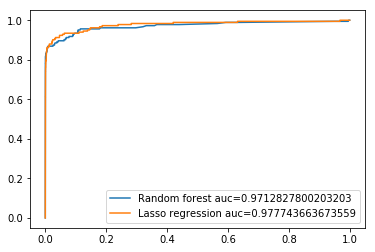

In [38]:
# plot the two curves
plt.plot(fpr1,tpr1,label="Random forest auc="+str(auc1))
plt.plot(fpr2,tpr2,label="Lasso regression auc="+str(auc2))
plt.legend(loc=4)
plt.show()

In [39]:
f1_score

{'under_sampled_forest': 0.9225589225589226,
 'under_sampled_lasso': 0.935483870967742,
 'SMOTE_random_forest': 0.15911602209944753,
 'SMOTE_laso': 0.0671591672263264,
 'regular_over_smp_forest': 0.16728037874802737,
 'regular_over_smp_lasso': 0.06983065021952749}

## conclusion
When looking at the f1 scores:\begin{equation*} 2*\frac{recall * precision}{recall + precision} \end{equation*} the under-sampling the data seems to perform much better than the others, even though there might be some data loss. 

Also, in general, random forest performs better than lasso regression